In [206]:
import os

# **Reading photos**

In [207]:
def run_fast_scandir(dir, ext):    
    subfolders, datafiles = [], []

    for f in os.scandir(dir):
        if f.is_dir():
            subfolders.append(f.path)
        if f.is_file():
            if os.path.splitext(f.name)[1].lower() in ext:
                datafiles.append(f.path)

    for dir in list(subfolders):
        sf, f = run_fast_scandir(dir, ext)
        subfolders.extend(sf)
        datafiles.extend(f)
    return subfolders, datafiles

# train_im_folder = "C:/Users/migue/OneDrive/Ambiente de Trabalho/Tese/AcquisitionProtocols/RSVP aerial imagery dataset/FEUP_JAN_21_DJI"
test_im_folder = "C:/Users/migue/OneDrive/Ambiente de Trabalho/Tese/AcquisitionProtocols/RSVP aerial imagery dataset/MADALENA_APR_18_DJI"


_, photos = run_fast_scandir(test_im_folder, ".jpg")

In [208]:
photos

['C:/Users/migue/OneDrive/Ambiente de Trabalho/Tese/AcquisitionProtocols/RSVP aerial imagery dataset/MADALENA_APR_18_DJI\\DJI_20240419154943_0263_D.JPG',
 'C:/Users/migue/OneDrive/Ambiente de Trabalho/Tese/AcquisitionProtocols/RSVP aerial imagery dataset/MADALENA_APR_18_DJI\\DJI_20240419154949_0264_D.JPG',
 'C:/Users/migue/OneDrive/Ambiente de Trabalho/Tese/AcquisitionProtocols/RSVP aerial imagery dataset/MADALENA_APR_18_DJI\\DJI_20240419154954_0265_D.JPG',
 'C:/Users/migue/OneDrive/Ambiente de Trabalho/Tese/AcquisitionProtocols/RSVP aerial imagery dataset/MADALENA_APR_18_DJI\\DJI_20240419155001_0266_D.JPG',
 'C:/Users/migue/OneDrive/Ambiente de Trabalho/Tese/AcquisitionProtocols/RSVP aerial imagery dataset/MADALENA_APR_18_DJI\\DJI_20240419155010_0267_D.JPG',
 'C:/Users/migue/OneDrive/Ambiente de Trabalho/Tese/AcquisitionProtocols/RSVP aerial imagery dataset/MADALENA_APR_18_DJI\\DJI_20240419155019_0268_D.JPG',
 'C:/Users/migue/OneDrive/Ambiente de Trabalho/Tese/AcquisitionProtocols/RSV

In [209]:
import cv2
import numpy as np

In [210]:
imgs = []
for im in photos:
    read_im = cv2.imread(im)
    imgs.append(read_im)

# **Cropping the images**

In [211]:
# Train Images:
# cropped_im_dir = "C:/Users/migue/OneDrive/Ambiente de Trabalho/Tese/AcquisitionProtocols/RSVP aerial imagery dataset/Cropped_FEUP_JAN_21_DJI"

# Test images: 
cropped_im_dir = "C:/Users/migue/OneDrive/Ambiente de Trabalho/Tese/AcquisitionProtocols/RSVP aerial imagery dataset/Cropped_MADALENA_APR_18_DJI"

In [212]:
# 2 x 3 cropping

DIV_HEIGHT = 2
DIV_WIDTH  = 3

if not os.path.exists(cropped_im_dir): # Check if the directory already exists
    os.makedirs(cropped_im_dir, exist_ok=True)
    # exist_ok=True: This is a parameter of the os.makedirs function. When exist_ok is set to True, it ensures that the function
    # does not raise an error if the directory already exists. This is redundant with the condition however.

    for c , im in enumerate(imgs): # Iteration over all the images
        print(f"Cropping image {c + 1}")

        height, width, color_ch = im.shape

        # // Is the integer division (rounded down)
        h = height // DIV_HEIGHT
        w = width // DIV_WIDTH

        for i in range(DIV_HEIGHT): # Horizontal subparts of the image

            start_y = i * h
            end_y = (i + 1) * h

            for j in range(DIV_WIDTH): # Vertical subparts of the image
                
                start_x = j * w
                end_x = (j + 1) * w

                cropped_im = im[start_y:end_y, start_x:end_x]

                if(c+1 < 10):
                    aux = "00"
                elif(c+1 >= 10 and c+1 < 100):
                    aux = "0"
                else:
                    aux = ""
                saving_path = f"{cropped_im_dir}/madalenaDrone_{aux}{c+1}_{i+1}x{j+1}.jpg"

                cv2.imwrite(saving_path, cropped_im)

else:
    print("Folder already exists.")

Folder already exists.


# **Finding the centroid of the red object (me) in the image**

## Using Deep learning model for human pose estimation

In [213]:
# https://github.com/opencv/opencv/blob/master/samples/dnn/openpose.py

'''

mod = "graph_opt.pb"
mod_path = f"C:/Users/migue/OneDrive/Ambiente de Trabalho/Tese/AcquisitionProtocols/HumanPoseModel/{mod}"
net = cv2.dnn.readNetFromTensorflow(mod_path) # Importing model (weights)

def pose_estimation(image):
    image = cv2.imread(image)

    height, width, _ = image.shape
    
    inHeight = height 
    inWidth = width
    thr = 0.2

    net.setInput(cv2.dnn.blobFromImage(image, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB = True, crop = False))
    out = net.forward()
    out = out[:,:19,:,:]

    BODY_PARTS = { "Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                    "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                    "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14,
                    "Background": 15 }

    POSE_PAIRS = [ ["Head", "Neck"], ["Neck", "RShoulder"], ["RShoulder", "RElbow"],
                    ["RElbow", "RWrist"], ["Neck", "LShoulder"], ["LShoulder", "LElbow"],
                    ["LElbow", "LWrist"], ["Neck", "Chest"], ["Chest", "RHip"], ["RHip", "RKnee"],
                    ["RKnee", "RAnkle"], ["Chest", "LHip"], ["LHip", "LKnee"], ["LKnee", "LAnkle"] ]
    

    points = []
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponding body's part.
        heatMap = out[0, i, :, :]

        # Originally, we try to find all the local maximums. To simplify a sample
        # we just find a global one. However only a single pose at the same time
        # could be detected this way.
        _, conf, _, point = cv2.minMaxLoc(heatMap)
        x = (width * point[0]) / out.shape[3]
        y = (height * point[1]) / out.shape[2]

        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv2.line(image, points[idFrom], points[idTo], (0, 0, 0), 3)
            cv2.ellipse(image, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv2.FILLED)
            cv2.ellipse(image, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv2.FILLED)

    t, _ = net.getPerfProfile()
    freq = cv2.getTickFrequency() / 1000

    return image


_, cropped_images = run_fast_scandir(cropped_im_dir, ".jpg")
for count, im in enumerate(cropped_images):
    pose = pose_estimation(im)
    cv2.imshow("Human detection", pose)
    cv2.waitKey(1500)
    cv2.destroyAllWindows()
    '''

'\n\nmod = "graph_opt.pb"\nmod_path = f"C:/Users/migue/OneDrive/Ambiente de Trabalho/Tese/AcquisitionProtocols/HumanPoseModel/{mod}"\nnet = cv2.dnn.readNetFromTensorflow(mod_path) # Importing model (weights)\n\ndef pose_estimation(image):\n    image = cv2.imread(image)\n\n    height, width, _ = image.shape\n    \n    inHeight = height \n    inWidth = width\n    thr = 0.2\n\n    net.setInput(cv2.dnn.blobFromImage(image, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB = True, crop = False))\n    out = net.forward()\n    out = out[:,:19,:,:]\n\n    BODY_PARTS = { "Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,\n                    "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,\n                    "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14,\n                    "Background": 15 }\n\n    POSE_PAIRS = [ ["Head", "Neck"], ["Neck", "RShoulder"], ["RShoulder", "RElbow"],\n                    ["RElbow", "RWrist"], ["Neck", "LShould

## Using a color mask

### Finding the specific HSV values of the target object (red color shirt)

In [214]:
object_color_image = cv2.imread("C:/Users/migue/OneDrive/Ambiente de Trabalho/Tese/AcquisitionProtocols/RSVP aerial imagery dataset/MADALENA_APR_18_DJI/targetObj_colorFinding.jpeg")
cv2.imshow('Test Image', object_color_image)
cv2.waitKey(3000)
cv2.destroyAllWindows()

# Convert BGR to HSV
hsv_image = cv2.cvtColor(object_color_image, cv2.COLOR_BGR2HSV)
cv2.imwrite("C:/Users/migue/OneDrive/Ambiente de Trabalho/Tese/AcquisitionProtocols/RSVP aerial imagery dataset/MADALENA_APR_18_DJI/targetObj_colorFinding_HSV.jpeg", hsv_image)

# Extract the H channel
h_channel = hsv_image[:, :, 0]
s_channel = hsv_image[:, :, 1]
v_channel = hsv_image[:, :, 2]

# Calculate the average value of all color channels
average_h = np.mean(h_channel)
average_s = np.mean(v_channel)
average_v = np.mean(v_channel)

# Calculate the standard variation of all color channels

std_h = np.std(h_channel)
std_s = np.std(s_channel)
std_v = np.std(v_channel)

print(f"Average H value: {average_h} +/- {std_h} | Average S value: {average_s} +/- {std_s} | Average V value: {average_v} +/- {std_v}" )

Average H value: 19.468864468864467 +/- 1.6441541998588096 | Average S value: 223.72115384615384 +/- 33.39554794270685 | Average V value: 223.72115384615384 +/- 39.89127383700561


### Function that displays the color HSV range determined according to cv2 package and finds the corresponding HEX color code

In [215]:
def hex_color_code(hue, saturation, value):

    # Convert HSV to BGR (OpenCV uses BGR by default)
    hsv_color = np.uint8([[([hue, saturation, value])]])  # Reshape for OpenCV
    bgr_color = cv2.cvtColor(hsv_color, cv2.COLOR_HSV2BGR)[0][0]

    # Extract BGR channels
    blue = bgr_color[0]
    green = bgr_color[1]
    red = bgr_color[2]

    # Convert each channel to a 2-digit hex string with zero-padding
    hex_code = "#" + format(red, '02x') + format(green, '02x') + format(blue, '02x')

    # Print the hex code
    print(f"Hue (0-179): {round(hue,3)} | Saturation (0-255): {round(saturation,3)} | Value (0-255): {round(value,3)} | Hex code: {hex_code}")

In [216]:
hex_color_code(173.340, 206.377, 206.377)

Hue (0-179): 173.34 | Saturation (0-255): 206.377 | Value (0-255): 206.377 | Hex code: #ce284e


### Apllying the correct HSV ranges for the target objects

The sub-images that only demonstrated the ceilling were eliminated, thus remaining 261 images on the DB (vs 378 originally) 

In [217]:
import pandas as pd

In [227]:
_, cropped_images = run_fast_scandir(cropped_im_dir, ".jpg")

'''
# Train range

clearance = 3   # Clearance: 3 x std
h_clearance = 5 # Clearance: 5 x std (Hue/color channel)
'''

# Test range

clearance = 2   # Clearance: 3 x std
h_clearance = 1 # Clearance: 5 x std (Hue/color channel)

all_hsvIms = []
all_conditions = []
all_centroids = []

t_count = 0
nt_count = 0

int_cent = []

# Defines the range of red color in HSV (https://colorpicker.me)
lower_red = np.array([average_h - h_clearance * std_h, average_s - clearance * std_s, average_v - clearance * std_v]) 
upper_red = np.array([average_h + h_clearance * std_h, average_s + clearance * std_s, average_v + clearance * std_v])

for count, im in enumerate(cropped_images):

    # Reads the image using OpenCV
    im = im.replace( '/', '\\')
    img = cv2.imread(im)
    img = cv2.resize(img, None, fx=0.5, fy=0.5)

    all_hsvIms.append(im)
        
    # Image sizes
    height, width, _ = img.shape
    print(f"------- Image {count + 1} -------")
    print(f"Image size: {height} x {width} px")

    # Converts the image from BGR to HSV color space
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) 
    
    #The image is converted to the HSV (Hue, Saturation, Value) color space because it provides a more 
    #intuitive way to represent colors, making it easier to isolate a specific color range, such as red.
    # This is because the whole color information is on the first channel, Hue.
        
    # Thresholds the image with a mask to get only red pixels
    ''' 
    This binarizes the portions of the image contained between the lower_red and upper_red range.
    The pixel values contained in that HSV range will have the value of 1 and the rest the value 
    of 0 on the binarized image.
    '''
    mask = cv2.inRange(hsv_img, lower_red, upper_red)

    # Finds contours in the binary image
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    '''
    cv2.RETR_EXTERNAL: This retrieves only the extreme outer contours. This means it will identify the outermost 
    boundaries of connected components in the foreground (white) regions of the mask image.

    cv2.CHAIN_APPROX_SIMPLE: This method stores only the endpoints of the contours, resulting in a more compressed 
    representation. This is useful for most basic contour analysis tasks as it reduces memory usage and processing time.
    '''

    if contours:
        # Finds the largest contour (assumed to be the red object)
        largest_contour = max(contours, key=cv2.contourArea)

        # Calculates the centroid of the largest contour
        moments = cv2.moments(largest_contour)

        # Checks if moments['m00'] is not zero before division
        if moments['m00'] != 0:
            # Target image was identified
            all_conditions.append("Target")
            t_count += 1

            if(t_count == 1):
                print("Saving images...")
                cv2.imwrite("C:/Users/migue/OneDrive/Ambiente de Trabalho/Tese/ImTese/HSV_target.png", hsv_img)
                cv2.imwrite("C:/Users/migue/OneDrive/Ambiente de Trabalho/Tese/ImTese/HSVmask_target.png", mask)

            # Image Processing: Moment of Image for Object Detection - https://www.youtube.com/watch?v=RCodqRopMHs
            ''' 
            M00     = Area of the target object in the image (Counts of 1 in the binarized image)
            M10/M00 = Center coordinate of the target object in the x axis
            M01/M00 = Center coordinate of the target object in the y axis
            M11     = Spread of the target object on the x and y directions
            '''
            centroid_x = int(moments['m10'] / moments['m00'])
            centroid_y = int(moments['m01'] / moments['m00'])
            print(f"Target found - Coordinates: [{centroid_x}, {centroid_y}]")
            all_centroids.append([f"x={centroid_x}, y={centroid_y}"])

            int_cent.append([centroid_x, centroid_y])

            # Draws a circle at the centroid
            cv2.circle(img, (centroid_x, centroid_y), 12, (255, 50, 50), -1) # radius = 15; thickness = -1; blueish = (255, 50, 50) in BGR
            
            # Displays the image with the centroid to check if the centroid is being determined correctly   
            
            cv2.imshow('Target image', img)
            cv2.waitKey(800) # Time that image stays on the screen in ms (Value of 0 makes the window stay open until manually closed)
            cv2.destroyAllWindows()  
            
            
        else:
            # Non target image was identified
            nt_count += 1
            
            all_conditions.append("NonTarget")
            all_centroids.append("0")
            
            print("Non target image")
    else:
        # Non target image was identified
        nt_count += 1

        all_conditions.append("NonTarget")
        all_centroids.append("0")
        
        print("Non target image")
        
        # Supervising/checking algor
        
        cv2.imshow('Non-target image',img)
        cv2.waitKey(400)
        cv2.destroyAllWindows()
        
    
    # Finding the HEX color codes of the HSV color range determined
    if (count == len(cropped_images) - 1):
        print("-----------------------------------------------")
        print("Lower HEX color value: ")
        hex_color_code(lower_red[0], lower_red[1], lower_red[2])
        print("Upper HEX color value: ")
        hex_color_code(upper_red[0], upper_red[1], upper_red[2])
        print("\n")
        
                  

------- Image 1 -------
Image size: 567 x 672 px
Non target image
------- Image 2 -------
Image size: 567 x 672 px
Non target image
------- Image 3 -------
Image size: 567 x 672 px
Non target image
------- Image 4 -------
Image size: 567 x 672 px
Non target image
------- Image 5 -------
Image size: 567 x 672 px
Non target image
------- Image 6 -------
Image size: 567 x 672 px
Non target image
------- Image 7 -------
Image size: 567 x 672 px
Non target image
------- Image 8 -------
Image size: 567 x 672 px
Non target image
------- Image 9 -------
Image size: 567 x 672 px
Non target image
------- Image 10 -------
Image size: 567 x 672 px
Saving images...
Target found - Coordinates: [375, 401]
------- Image 11 -------
Image size: 567 x 672 px
Target found - Coordinates: [295, 164]
------- Image 12 -------
Image size: 567 x 672 px
Non target image
------- Image 13 -------
Image size: 567 x 672 px
Non target image
------- Image 14 -------
Image size: 567 x 672 px
Non target image
------- Im

(567.0, 0.0)

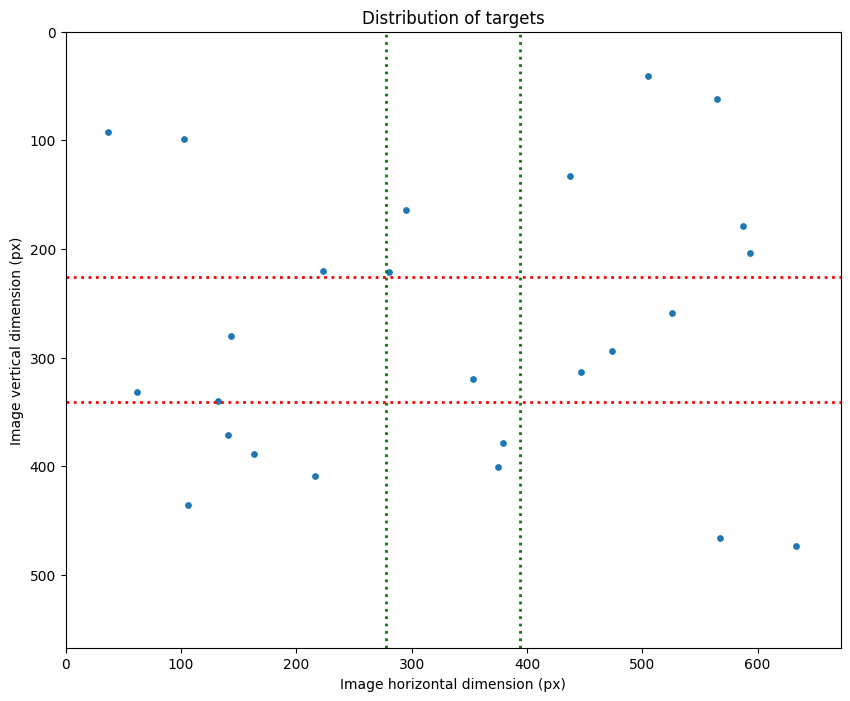

In [219]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

int_cent = np.array(int_cent)

figure(figsize = (10, 8))

plt.scatter(int_cent[:,0], int_cent[:,1], s = 15);
plt.xlabel("Image horizontal dimension (px)")
plt.ylabel("Image vertical dimension (px)")
plt.title("Distribution of targets")

plt.axvline(x = 278, color = 'g', linestyle = ':', linewidth = 2)
plt.axvline(x = 394, color = 'g', linestyle = ':', linewidth = 2)

plt.axhline(y = 226, color = 'r', linestyle = ':', linewidth = 2)
plt.axhline(y = 341, color = 'r', linestyle = ':', linewidth = 2)

plt.xlim([0, width]);
plt.ylim([height, 0])



In [220]:
print((176.388 - 170.388) / 3)
print((100 * (240.449 - 173.307) / 255 / 3))
print((100 * (263.092 - 149.664) / 255 / 3))

print(((240.449 - 173.307) / 3))
print(((263.092 - 149.664) / 3))

2.0
8.776732026143794
14.827189542483659
22.380666666666674
37.809333333333335


In [221]:
hex_color_code(170.388 + 2, 172.307 + 22, 149.664 + 37)

Hue (0-179): 172.388 | Saturation (0-255): 194.307 | Value (0-255): 186.664 | Hex code: #ba2c52


In [222]:
# Checking size of arrays

print(len(all_hsvIms))
print(len(all_conditions))
print(len(all_centroids))

345
345
345


### Writting the dataframe into an excel sheet

In [223]:
import random

In [226]:
# Check for duplicates based on entire rows
unique = np.unique(all_hsvIms)

excel_file = "MADALENA_droneImages.xlsx"
protocol_path = "C:/Users/migue/OneDrive/Ambiente de Trabalho/Tese/AcquisitionProtocols/"

if not os.path.exists(protocol_path + excel_file):
    if len(unique) == len(all_hsvIms):
        # Creating pandas Dataframe
        df = pd.DataFrame({"Image" : all_hsvIms, "Condition" : all_conditions, "Centroid" : all_centroids})
        
        # Slicing the required number of Non Target images to maintain the 10% oddball rule
        n_targets = len(df[df["Condition"] == "Target"])
        p = 10 # (%) Proportion of targets to non targets
        sliced_df = pd.concat([df[df["Condition"] == "Target"], df[df["Condition"] == "NonTarget"][0:n_targets * p - n_targets]], ignore_index = True) 
        print("Dataframe size: ", sliced_df.shape)
        
        # Random shuffling the concatenated data 3x
        permutation1 = np.random.permutation(sliced_df.index)
        sliced_df = sliced_df.iloc[permutation1]
        permutation2 = np.random.permutation(sliced_df.index)
        sliced_df = sliced_df.iloc[permutation2]
        permutation3 = np.random.permutation(sliced_df.index)
        sliced_df = sliced_df.iloc[permutation3]

        # Writting to excel
        sliced_df.to_excel(protocol_path + excel_file, sheet_name = "sheet1", index = False)
    else:
        print("Duplicate entries found!")
else:
    print("File already exists!")
    

Dataframe size:  (250, 3)
